In [1]:
import pylab as plt
import imageio
import os
import numpy as np
import pandas as pd
import time
import utils
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from torch.autograd import Function
from torch.autograd import Variable

from skimage.transform import resize
import cv2

## Util Functions

In [2]:
def path_label_loader(path):
    """
    Args:
     path: Folder path containing subfolders of images
    Output:
     images: List of image path
     labels: Numpy array of labels
    """
    images = []
    labels = []
    
    for s_folder in os.listdir(path):
        label = int(''.join([s for s in s_folder if s.isdigit()]))
        img_folder = os.path.join(path, s_folder)
        
        for img in os.listdir(img_folder):
            if img.endswith(".jpg"):
                image_path = os.path.join(img_folder, img)
                images.append(image_path)
                labels.append(label)
                
    labels = np.array(labels) - 1
    images = np.array(images)
                
    return images, labels

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir,labels, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = labels


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        img = read_image(img_path, ImageReadMode.RGB).float()
        if self.transform != False:
            img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

In [4]:
def create_data_loader(img_path, img_label, batch_size):
    transform = transforms.Compose([
        transforms.Resize(size = (128,128)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
        
    
    dataset = CustomImageDataset(img_path, img_label, transform)

    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    
    return data_loader

In [5]:
def eval_on_test_set(net, test_loader,is_cnn = True, verbose=1):
    
    total_error = 0
    batch_num = 0
    
    for test_data, test_label in test_loader:
        
        bs = test_label.shape[0]
        test_data=test_data.to(device)
        test_label=test_label.to(device)
        
        if is_cnn:
            inputs = test_data
        else:
            inputs = test_data.view(bs, 128*128*3)
        
        scores=net( inputs ) 

        error = utils.get_error( scores , test_label)

        total_error += error.item()
        
        batch_num += 1
        
    total_error = total_error / batch_num
    
    if verbose == 1:
        print( 'error rate on test set =', total_error*100 ,'percent\n')
        
    return total_error

In [6]:
def train_model(net, n_epoch, my_lr, train_loader, test_loader, is_cnn = True, momentum=0.9, verbose=1):
    """
    Train a given model with specified hyperparameters
    
    Args:
     net: NN model to be trained
     n_epoch: Number of epochs to train the model
     bs: Batch size for minibatch GD
     lr: Learning rate of GD
     train_data: Torch tensor of dim [N:rgb:width:height]
     train_label: Torch tensor of dim [N]
     verbose: Print out metrics during training if 1, default 1
    
    Output:
     net: Trained NN model
     records: Dictionary containing metrics history, including training loss/error for each epoch/minibatch, test error for each epoch
    """
    
    N = len(train_loader)
    
    net = net.to(device)
    
    train_loss_hist_mb = []
    train_loss_hist = []
    train_error_hist = []
    test_error_hist = []
    
    start=time.time()

    for epoch in range(1,n_epoch+1):

        if not epoch%5:
            my_lr = my_lr / 1.5

        # optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, momentum=momentum )
        optimizer=torch.optim.Adam(net.parameters(), lr=my_lr)

        running_loss=0
        running_error=0
        num_batches=0
            
        for minibatch_data, minibatch_label in train_loader:


            # FORWARD AND BACKWARD PASS
            bs = minibatch_label.shape[0]

            optimizer.zero_grad()


            minibatch_data=minibatch_data.to(device)                
            minibatch_label=minibatch_label.to(device)

            if is_cnn:
                inputs = minibatch_data
            else:                    
                inputs = minibatch_data.view(bs, 128*128*3)


            inputs.requires_grad_()

            scores=net( inputs ) 

            loss =  criterion( scores , minibatch_label.long()) 

            loss.backward()
            
            optimizer.step()


            # COMPUTE STATS
            running_loss += loss.detach().item()

            error = utils.get_error( scores.detach() , minibatch_label)
            running_error += error.item()

            num_batches+=1   
            train_loss_hist_mb.append(running_error/num_batches)
                
        # AVERAGE STATS THEN DISPLAY
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = (time.time()-start)/60

        if verbose == 1:
            print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        test_error = eval_on_test_set(net, test_loader,is_cnn = is_cnn, verbose=verbose) 
        
        train_loss_hist.append(total_loss)
        train_error_hist.append(total_error)
        test_error_hist.append(test_error)
    
    records = {'train_loss_mb': train_loss_hist_mb,
              'train_loss': train_loss_hist,
              'train_error': train_error_hist,
              'test_error': test_error_hist}
        
    return records

## Classification Models

### MLP

In [7]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1)
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2)
        self.layer3 = nn.Linear(  hidden_size2 , output_size)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

### LeNet

In [8]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()
        
        self.layer = nn.Sequential(
            # CL1:   3 * 128 x 128  -->    50 x 128 x 128 
            nn.Conv2d(3,   50,  kernel_size=3,  padding=1 ),
            nn.ReLU(),

            # MP1: 50 x 128 x 128 -->    50 x 64 x 64
            nn.MaxPool2d(2,2),

            # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
            nn.Conv2d(50,  100,  kernel_size=3,  padding=1 ),
            nn.ReLU(),

            # MP2: 100 x 64 x 64 -->    100 x 32 x 32
            nn.MaxPool2d(2,2),
            
            # MP3: 100 * 32 * 32 -> 100 * 32 * 32 (Grad needed for later CAM)
            nn.Conv2d(100,100, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.fc_layer = nn.Sequential(
            # LL1:   100 x 32 x 32 = 102400 -->  100 
            nn.Linear(102400, 100),
            nn.ReLU(),

            # LL2:   100  -->  13 
            nn.Linear(100,13),
        )

#         # CL1:   3 * 128 x 128  -->    50 x 128 x 128 
#         self.conv1 = nn.Conv2d(3,   50,  kernel_size=3,  padding=1 )
        
#         # MP1: 50 x 128 x 128 -->    50 x 64 x 64
#         self.pool1  = nn.MaxPool2d(2,2)
        
#         # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
#         self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
#         # MP2: 100 x 64 x 64 -->    100 x 32 x 32
#         self.pool2 = nn.MaxPool2d(2,2)
        
#         # LL1:   100 x 32 x 32 = 102400 -->  100 
#         self.linear1 = nn.Linear(102400, 100)
        
#         # LL2:   100  -->  13 
#         self.linear2 = nn.Linear(100,13)


    def forward(self, x):
        out = self.layer(x)
        out = out.view(-1, 102400)
        out = self.fc_layer(out)

#         # CL1:   128 x 28  -->    50 x 28 x 28 
#         x = self.conv1(x)
#         x = torch.relu(x)
        
#         # MP1: 50 x 28 x 28 -->    50 x 14 x 14
#         x = self.pool1(x)
        
#         # CL2:   50 x 14 x 14  -->    100 x 14 x 14
#         x = self.conv2(x)
#         x = torch.relu(x)
        
#         # MP2: 100 x 14 x 14 -->    100 x 7 x 7
#         x = self.pool2(x)

#         # LL1:   100 x 7 x 7 = 4900  -->  100 
#         x = x.view(-1, 102400)
#         x = self.linear1(x)
#         x = torch.relu(x)
        
#         # LL2:   4900  -->  10 
#         x = self.linear2(x)
    
        return out

### Example CNN

In [124]:
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        
        self.layer = nn.Sequential(
            # 3x128x128 -> 32*128*128
            nn.Conv2d(3,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            # 32x128x128 -> 32x64x64
            nn.AvgPool2d(2,2), # Added
            # 32x64x64 -> 64x64x64
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            # 64x64x64 -> 64x32x32
            nn.AvgPool2d(2,2),
            
            # 64x32x32 -> 128x32x32
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            # 128x32x32 -> 128x16x16
            nn.AvgPool2d(2,2),
            
            # 128x16x16 -> 256x16x16
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),

        )
        self.fc_layer = nn.Sequential(
            # nn.Linear(self.num_feature*4*32*32,1000),
            # nn.ReLU(),
            # nn.Linear(1000,13)
            # (256, 13)
            nn.Linear(self.num_feature*8*16*16,13)
        )       
        
    def forward(self,x):
        bz = x.size()[0]
        out = self.layer(x) # (bz, 256, 16, 16)
        out = out.view(bz, self.num_feature*8*16*16)
        out = self.fc_layer(out) # (256, 13)

        return out

## Load Data

In [10]:
path = "../data/clean_images_index"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, "is running")

images, labels = path_label_loader(path)
print(len(images))
print(len(labels))

cuda is running
2061
2061


In [11]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([156, 152, 156, 170, 150, 129, 178, 141, 185, 159, 152, 161, 172],
       dtype=int64))

In [12]:
# Use 1648 images as training set and 413 images as test set
train_indice = np.random.choice(2061, 1648, replace=False)
train_path = images[train_indice]
train_label = labels[train_indice]
test_path = images[~train_indice]
test_label = labels[~train_indice]

In [13]:
train_loader = create_data_loader(train_path, train_label, 32)
test_loader = create_data_loader(test_path, test_label, 32)
criterion = nn.CrossEntropyLoss()

## Classification Model Training

In [14]:
my_mlp=mlp(128*128*3, 50, 50, 13)
my_mlp.to(device)
print(my_mlp)

mlp(
  (layer1): Linear(in_features=49152, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=13, bias=True)
)


In [17]:
mlp_record = train_model(net = my_mlp, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = False, verbose=1)

epoch= 1 	 time= 0.1922277530034383 min 	 lr= 0.0001 	 loss= 353036.9256910269 	 error= 92.54807692307693 percent
error rate on test set = 92.8485576923077 percent

epoch= 2 	 time= 0.5093631148338318 min 	 lr= 0.0001 	 loss= 38.90050524014693 	 error= 92.24759615384616 percent
error rate on test set = 92.90865384615384 percent

epoch= 3 	 time= 0.8266697525978088 min 	 lr= 0.0001 	 loss= 2.6318547129631042 	 error= 91.82692307692307 percent
error rate on test set = 91.76682692307693 percent

epoch= 4 	 time= 1.1481894731521607 min 	 lr= 0.0001 	 loss= 2.5993426258747396 	 error= 91.5264423076923 percent
error rate on test set = 91.82692307692307 percent

epoch= 5 	 time= 1.4695101062456766 min 	 lr= 6.666666666666667e-05 	 loss= 2.5824398398399353 	 error= 91.70673076923077 percent
error rate on test set = 91.82692307692307 percent

epoch= 6 	 time= 1.7918424169222513 min 	 lr= 6.666666666666667e-05 	 loss= 2.575266416256244 	 error= 91.58653846153845 percent
error rate on test set = 

In [15]:
my_lenet = LeNet5_convnet()
my_lenet.to(device)
print(my_lenet)

LeNet5_convnet(
  (layer): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=102400, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=13, bias=True)
  )
)


In [14]:
# loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(my_lenet.parameters(), lr=1e-4)
# model = my_lenet

# num_epoch = 10
# for i in range(num_epoch):
#     my_lenet.train()
#     for j,[image,label] in enumerate(train_loader):
#         x = Variable(image).cuda()
#         y_= Variable(label).cuda()
        
#         optimizer.zero_grad()
#         output = model.forward(x)
#         loss = loss_func(output,y_.long())
#         loss.backward()
#         optimizer.step()
        
         
#     top_1_count = torch.FloatTensor([0])
#     total = torch.FloatTensor([0])
#     model.eval() 
#     for image,label in test_loader:
#         x = Variable(image,volatile=True).cuda()
#         y_= Variable(label).cuda()

#         output = model.forward(x)
        
#         values,idx = output.max(dim=1)
#         top_1_count += torch.sum(y_==idx).float().cpu().data

#         total += label.size(0)

#     print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
#     if (top_1_count/total).numpy() > 0.98:
#         break

In [14]:
lenet_record = train_model(net = my_lenet, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader, verbose=1)

C:\Users\z9906\Anaconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch= 1 	 time= 0.7662309726079305 min 	 lr= 0.0001 	 loss= 22.26104052708699 	 error= 87.80048076923077 percent
error rate on test set = 75.1201923076923 percent

epoch= 2 	 time= 3.054610753059387 min 	 lr= 0.0001 	 loss= 1.8593696447519155 	 error= 60.09615384615385 percent
error rate on test set = 30.76923076923077 percent

epoch= 3 	 time= 5.284654057025909 min 	 lr= 0.0001 	 loss= 0.8165055175240223 	 error= 26.08173076923077 percent
error rate on test set = 12.5 percent



KeyboardInterrupt: 

In [125]:
eg_CNN = CNN()
eg_CNN.to(device)
print(eg_CNN)

CNN(
  (layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=65536, out_features=

In [127]:
cnn_record = train_model(net = eg_CNN, n_epoch = 10, my_lr = 1e-3, train_loader = train_loader, test_loader = test_loader, verbose=1)

epoch= 1 	 time= 0.9997264822324117 min 	 lr= 0.001 	 loss= 9.930108487606049 	 error= 77.04326923076923 percent
error rate on test set = 66.82692307692307 percent

epoch= 2 	 time= 2.4679778019587197 min 	 lr= 0.001 	 loss= 7.493257595942571 	 error= 70.13221153846155 percent
error rate on test set = 66.46634615384616 percent

epoch= 3 	 time= 3.9325034260749816 min 	 lr= 0.001 	 loss= 5.72494389460637 	 error= 63.10096153846154 percent
error rate on test set = 50.18028846153846 percent

epoch= 4 	 time= 5.399926523367564 min 	 lr= 0.001 	 loss= 3.2960898876190186 	 error= 51.262019230769226 percent
error rate on test set = 43.08894230769231 percent

epoch= 5 	 time= 6.848945156733195 min 	 lr= 0.0006666666666666666 	 loss= 1.9057219188946943 	 error= 40.86538461538461 percent
error rate on test set = 37.800480769230774 percent

epoch= 6 	 time= 8.361087354024251 min 	 lr= 0.0006666666666666666 	 loss= 1.5765746270234768 	 error= 33.77403846153847 percent
error rate on test set = 30.8

KeyboardInterrupt: 

## Save Models

In [70]:
import pickle
file_to_store = open("cnn.pickle", "wb")
pickle.dump(eg_CNN, file_to_store)


file_to_store.close()

In [31]:
import pickle
file_to_read = open("cnn.pickle", "rb")

eg_CNN = pickle.load(file_to_read)

file_to_read.close()

In [57]:
# import pickle
# file_to_store = open("lenet.pickle", "wb")
# pickle.dump(my_lenet, file_to_store)


# file_to_store.close()

In [18]:
# import pickle
# file_to_read = open("lenet.pickle", "rb")

# my_lenet = pickle.load(file_to_read)

# file_to_read.close()

In [21]:
class GuidedBackpropRelu(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
     
guided_relu = GuidedBackpropRelu.apply

In [22]:
class GuidedReluModel(nn.Module):
    def __init__(self,model,to_be_replaced,replace_to):
        super(GuidedReluModel,self).__init__()
        self.model = model
        self.to_be_replaced = to_be_replaced
        self.replace_to = replace_to
        self.layers=[]
        self.output=[]
        
        for m in self.model.modules():
            if isinstance(m,self.to_be_replaced):
                self.layers.append(self.replace_to )
                #self.layers.append(m)
            elif isinstance(m,nn.Conv2d):
                self.layers.append(m)
            elif isinstance(m,nn.BatchNorm2d):
                self.layers.append(m)
            elif isinstance(m,nn.Linear):
                self.layers.append(m)
            elif isinstance(m,nn.AvgPool2d):
                self.layers.append(m)
                
        for i in self.layers:
            print(i)
        
        
    def reset_output(self):
        self.output = []
    
    def hook(self,grad):
        out = grad[:,0,:,:].cpu().data#.numpy()
        print("out_size:",out.size())
        self.output.append(out)
        
    def get_visual(self,idx,original_img):
        grad = self.output[0][idx]
        return grad
        
    def forward(self,x):
        out = x 
        out.register_hook(self.hook)
        for i in self.layers[:-3]:
            out = i(out)
        out = out.view(out.size()[0],-1)
        for j in self.layers[-3:]:
            out = j(out)
        return out

In [33]:
class CAM():
    def __init__(self,model):
        self.gradient = []
        self.model = model
        self.h = self.model.model.layer[-2].register_backward_hook(self.save_gradient)
        
    def save_gradient(self,*args):
        #print("Gradient saved!!!!")
        grad_input = args[1]
        grad_output= args[2]
        self.gradient.append(grad_output[0])
        #print(self.gradient[0].size())
        
    def get_gradient(self):
        return self.gradient[0]
    
    def remove_hook(self):
        self.h.remove()
            
    def normalize_cam(self,x):
        x = 2*(x-torch.min(x))/(torch.max(x)-torch.min(x)+1e-8)-1
        #x[x<torch.max(x)]=-1
        return x
    
    def visualize(self,cam_img,guided_img,img_var):
        guided_img = guided_img.numpy()
        cam_img = resize(cam_img.cpu().data.numpy(),output_shape=(28,28))
        x = img_var[0,:,:].cpu().data.numpy()

        fig = plt.figure(figsize=(20, 12)) 
        
        plt.subplot(1,4,1)
        plt.title("Original Image")
        plt.imshow(x,cmap="gray")

        plt.subplot(1,4,2)
        plt.title("Class Activation Map")
        plt.imshow(cam_img)

        plt.subplot(1,4,3)
        plt.title("Guided Backpropagation")
        plt.imshow(guided_img,cmap='gray')
        
        plt.subplot(1,4,4)
        plt.title("Guided x CAM")
        plt.imshow(guided_img*cam_img,cmap="gray")
        plt.show()
    
    def get_cam(self,idx):
        grad = self.get_gradient()
        alpha = torch.sum(grad,dim=3,keepdim=True)
        alpha = torch.sum(alpha,dim=2,keepdim=True)
        
        cam = alpha[idx]*grad[idx]
        cam = torch.sum(cam,dim=0)
        cam = self.normalize_cam(cam)
        self.remove_hook()
        
        return cam

# CAM

In [135]:
model = eg_CNN
params = list(model.fc_layer.parameters())
weight = np.squeeze(params[0].cpu().data.numpy())
print('weight.shape', weight.shape)

weight.shape (13, 65536)


In [148]:
image, label = next(iter(test_loader))
# image = image[0].reshape(1,3,128,128)
# label = label[0]

model.eval()
scores = model(image.cuda()) # get the raw scores
probs = torch.nn.functional.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores
probs, idx = probs.sort(-1, True) # sort the probability distribution in descending order, and idx[0] is the predicted class
print('sum of probabilities: %.0f'%torch.sum(probs.cpu().data).numpy())
print('true class: ', label.cpu().numpy())
print('predicated class: ', idx[:,0].cpu().numpy())

sum of probabilities: 32
true class:  [ 6 10  3  3  9  1  3  4 12  2 11  8  4  5 11  7  5  0  3  4  1  5  2  4
  6 10 11  8 11  7  6  0]
predicated class:  [ 6 10  3  3  9  1  3  4 12 12 11 10  4  5  0  7  5  0  3  6  1  5  7  8
  6 10 11  8 11  7  6  0]


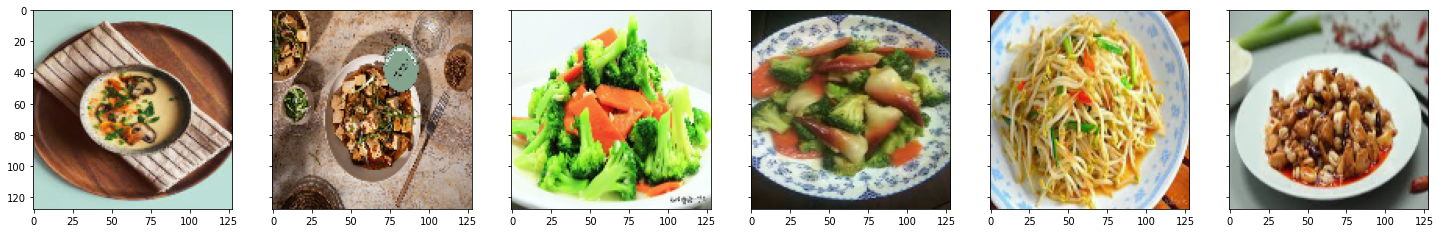

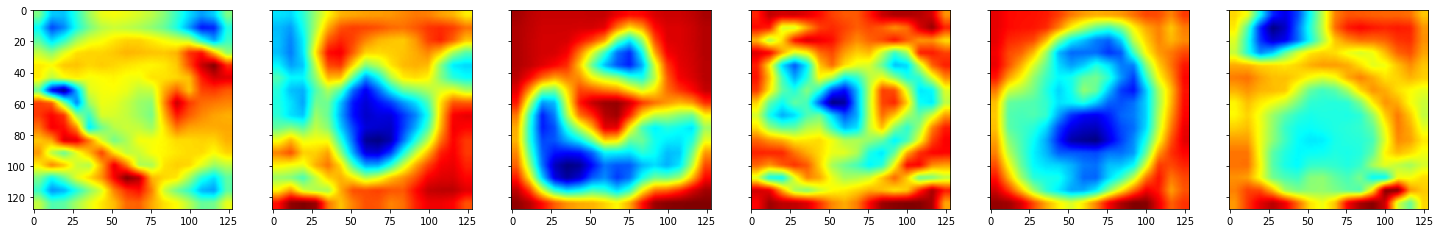

In [157]:
def return_CAM(feature_conv, weight, class_idx):
    """
    return_CAM generates the CAMs and up-sample it to 224x224
    arguments:
    feature_conv: the feature maps of the last convolutional layer
    weight: the weights that have been extracted from the trained parameters
    class_idx: the label of the class which has the highest probability
    """
    size_upsample = (128, 128)
    
    # we only consider one input image at a time, therefore in the case of 
    # VGG16, the shape is (1, 512, 7, 7)
    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    i = 0
    for idx in class_idx:
        # print('idx', idx)
        beforeDot =  feature_conv[i].reshape((nc, h*w))# -> (256, 16*16)
        # print('beforeDot.shape', beforeDot.shape)
        weight_reshaped = weight[idx].reshape((256, 16*16)) # (256, 16*16)
        weight_temp = np.mean(weight_reshaped, axis=-1) # (256,1)
        cam = np.matmul(weight_temp.T, beforeDot) # -> (1, 256) x (256,16*16) = (1,16*16)
        # print('weight.shape', weight[idx].shape)
        cam = cam.reshape(h, w) # -> (16 ,16)
        # global temp
        # temp = cam
        cam = cam.numpy()
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
        i += 1
    return output_cam


feature_maps = model.layer(image.cuda()) # get the feature maps of the last convolutional layer
# print('feature_maps.shape: ', feature_maps.cpu().detach().numpy().shape)

CAMs = return_CAM(feature_maps.cpu().detach(), weight, idx.cpu().numpy()[:,0]) # generate the CAM for the input image

# for i in range(5):
    
#     heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET)
#     disp_img = image[i]
#     print('original image shape: ', disp_img.reshape((3, 128, 128)).numpy().transpose((1,2,0)).shape)
#     print('heatmap.shape:', heatmap.shape)
#     disp_img = disp_img.reshape((3, 128, 128)).numpy().transpose((1, 2, 0)) 
#     # mean = np.array([0.485, 0.456, 0.406])
#     # std = np.array([0.229, 0.224, 0.225])
#     # image = image * std + mean
#     # image = np.clip(image, 0, 1)
#     disp_img = disp_img / 255. / 4

#     plt.imshow(disp_img)
#     plt.show()
#     plt.imshow(heatmap)
#     plt.show()

#     result = 0.5 * heatmap + 0.5 * disp_img
#     cv2.imwrite('cam.png', result)

fig, axes = plt.subplots(1,6, sharex=True, sharey=True, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET)
    disp_img = image[i]
    disp_img = disp_img.reshape((3, 128, 128)).numpy().transpose((1, 2, 0)) 
    disp_img = disp_img - disp_img.min()
    disp_img = disp_img / disp_img.max()

    ax.imshow(disp_img)


plt.show()

fig, axes = plt.subplots(1,6, sharex=True, sharey=True, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    heatmap = cv2.applyColorMap(CAMs[i], cv2.COLORMAP_JET)
    disp_img = image[i]
    disp_img = disp_img.reshape((3, 128, 128)).numpy().transpose((1, 2, 0)) 
    disp_img = disp_img / 255. / 4
    
    ax.imshow(heatmap)
      
plt.show()